In [110]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import sympy as sym
plt.style.use('presentation.mplstyle')
%matplotlib notebook

def d2np(d):
    
    names = []
    numbers = ()
    dtypes = []
    for item in d:
        names += item   
        if type(d[item]) == float:
            numbers += (d[item],)
            dtypes += [(item,float)]
        if type(d[item]) == int:
            numbers += (d[item],)
            dtypes += [(item,int)]
        if type(d[item]) == np.ndarray:
            numbers += (d[item],)
            dtypes += [(item,np.float64,d[item].shape)]
    return np.array([numbers],dtype=dtypes)



### Fortescue

In [111]:
alpha = np.exp(2.0/3*np.pi*1j)
A_0a =  np.array([[1, 1, 1],
                  [1, alpha**2, alpha],
                  [1, alpha, alpha**2]])

A_a0 = 1/3* np.array([[1, 1, 1],
                      [1, alpha, alpha**2],
                      [1, alpha**2, alpha]])

### Voltage source

In [112]:
theta = np.deg2rad(0.0)
V_zero =  0.0*np.exp(1j*0.0)
V_neg  =50.0*np.exp(1j*0.0)
V_pos  =400.0/np.sqrt(3)*np.exp(1j*theta)

V_012 = np.array([[V_zero],[V_pos],[V_neg]])

V_abc = A_0a @ V_012

### Control inputs

In [168]:
L = 500e-6
R = 0.01
omega = 2.0*np.pi*50.0
v_dc = 800.0


V_012 = A_a0 @ V_abc 
v_z = V_012[0,0]
v_p = V_012[1,0]
v_n = V_012[2,0]

### PLL

In [169]:
theta_pll = np.angle(v_p)

### Park

In [170]:
v_dq_z = v_z*np.exp(-1j*theta_pll)*np.sqrt(2)
v_dq_p = v_p*np.exp(-1j*theta_pll)*np.sqrt(2)
v_dq_n = v_n*np.exp( 1j*theta_pll)*np.sqrt(2)

v_d_z = v_dq_z.real
v_q_z = v_dq_z.imag
v_d_p = v_dq_p.real
v_q_p = v_dq_p.imag
v_d_n = v_dq_n.real
v_q_n = v_dq_n.imag

In [171]:
v_d_p

326.59863237109045

### References

In [182]:
p_ref = 0.1e6
q_ref = 0.0e6

pq_ref = np.array([p_ref,q_ref,0,0]).reshape(4,1)
i2p=3/2*np.array([[ v_d_p, v_q_p, v_d_n, v_q_n],  # i_d_p
                  [-v_q_p, v_d_p,-v_q_n, v_d_n],  # i_q_p
                  [-v_q_n, v_d_n, v_q_p,-v_d_p],  # i_d_n
                  [ v_d_n, v_q_n, v_d_p, v_q_p]]) # i_q_n


p2i=np.linalg.inv(i2p)

i_dq_pn = p2i@pq_ref

i_d_p_ref = 100.0
i_q_p_ref = 0.0
i_d_n_ref = 0.0
i_q_n_ref = 0.0

i_d_p_ref = i_dq_pn[0,0]
i_q_p_ref = i_dq_pn[1,0]
i_d_n_ref = i_dq_pn[2,0]
i_q_n_ref = i_dq_pn[3,0]

mode = 'p_cte'

if mode == 'p_pos_i_n_0':
    i_d_p_ref = 2/3*(-p_ref*v_d_p*(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2) + q_ref*v_q_p*(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2))/(v_d_n**4 + 2.0*v_d_n**2*v_q_n**2 - v_d_p**4 - 2.0*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)
    i_q_p_ref = -(2/3*p_ref*v_q_p*(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2) + 0.666666666666667*q_ref*v_d_p*(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2))/(v_d_n**4 + 2.0*v_d_n**2*v_q_n**2 - v_d_p**4 - 2.0*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)
    i_d_n_ref = 0
    i_q_n_ref = 0
    
if mode == 'p_cte':
    i_d_p_ref = 2/3*(-p_ref*v_d_p*(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2) + q_ref*v_q_p*(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2))/(v_d_n**4 + 2.0*v_d_n**2*v_q_n**2 - v_d_p**4 - 2.0*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)
    i_q_p_ref = -(2/3*p_ref*v_q_p*(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2) + 0.666666666666667*q_ref*v_d_p*(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2))/(v_d_n**4 + 2.0*v_d_n**2*v_q_n**2 - v_d_p**4 - 2.0*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)
    i_d_n_ref = 2/3*(p_ref*v_d_n*(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2) + q_ref*v_q_n*(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2))/(v_d_n**4 + 2.0*v_d_n**2*v_q_n**2 - v_d_p**4 - 2.0*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)
    i_q_n_ref = 2/3*(p_ref*v_q_n*(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2) - q_ref*v_d_n*(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2))/(v_d_n**4 + 2.0*v_d_n**2*v_q_n**2 - v_d_p**4 - 2.0*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)

if mode == 'q_cte':
    i_d_p_ref = 0.666666666666667*(p_ref*v_d_p*(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2) - q_ref*v_q_p*(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2))/(v_d_n**4 + 2.0*v_d_n**2*v_q_n**2 - v_d_p**4 - 2.0*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)
    i_q_p_ref = 0.666666666666667*(p_ref*v_q_p*(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2) + q_ref*v_d_p*(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2))/(v_d_n**4 + 2.0*v_d_n**2*v_q_n**2 - v_d_p**4 - 2.0*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)
    i_d_n_ref = 0.666666666666667*(p_ref*v_d_n*(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2) + q_ref*v_q_n*(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2))/(v_d_n**4 + 2.0*v_d_n**2*v_q_n**2 - v_d_p**4 - 2.0*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)
    i_q_n_ref = 0.666666666666667*(p_ref*v_q_n*(v_d_n**2 - v_d_p**2 + v_q_n**2 - v_q_p**2) - q_ref*v_d_n*(v_d_n**2 + v_d_p**2 + v_q_n**2 + v_q_p**2))/(v_d_n**4 + 2.0*v_d_n**2*v_q_n**2 - v_d_p**4 - 2.0*v_d_p**2*v_q_p**2 + v_q_n**4 - v_q_p**4)
    
if mode == 'pq_cte':
    i_d_p_ref = -0.333333333333333*v_q_n*(p_ref*(v_d_n*v_d_p + v_q_n*v_q_p) - q_ref*(v_d_n*v_q_p - v_d_p*v_q_n))/(v_d_n**2*v_d_p*v_q_p - v_d_n*v_d_p**2*v_q_n + v_d_n*v_q_n*v_q_p**2 - v_d_p*v_q_n**2*v_q_p)
    i_q_p_ref = 0.333333333333333*v_d_n*(p_ref*(v_d_n*v_d_p + v_q_n*v_q_p) - q_ref*(v_d_n*v_q_p - v_d_p*v_q_n))/(v_d_n**2*v_d_p*v_q_p - v_d_n*v_d_p**2*v_q_n + v_d_n*v_q_n*v_q_p**2 - v_d_p*v_q_n**2*v_q_p)
    i_d_n_ref = 0.333333333333333*v_q_p*(p_ref*(v_d_n*v_d_p + v_q_n*v_q_p) + q_ref*(v_d_n*v_q_p - v_d_p*v_q_n))/(v_d_n**2*v_d_p*v_q_p - v_d_n*v_d_p**2*v_q_n + v_d_n*v_q_n*v_q_p**2 - v_d_p*v_q_n**2*v_q_p)
    i_q_n_ref = -0.333333333333333*v_d_p*(p_ref*(v_d_n*v_d_p + v_q_n*v_q_p) + q_ref*(v_d_n*v_q_p - v_d_p*v_q_n))/(v_d_n**2*v_d_p*v_q_p - v_d_n*v_d_p**2*v_q_n + v_d_n*v_q_n*v_q_p**2 - v_d_p*v_q_n**2*v_q_p)


### Control

In [183]:
eta_d_p = 2.0/v_dc*(R*i_d_p_ref - L*omega*i_q_p_ref + v_d_p)
eta_q_p = 2.0/v_dc*(R*i_q_p_ref + L*omega*i_d_p_ref + v_q_p)
eta_d_n = 2.0/v_dc*(R*i_d_n_ref - L*omega*i_q_n_ref + v_d_n)
eta_q_n = 2.0/v_dc*(R*i_q_n_ref + L*omega*i_d_n_ref + v_q_n)

eta_dq_p = eta_d_p + 1j*eta_q_p
e_dq_p = v_dc/2.0*eta_dq_p       # phase-neutral peak value
 
eta_dq_n = eta_d_n + 1j*eta_q_n
e_dq_n = v_dc/2.0*eta_dq_n       # phase-neutral peak value

### Modulation

In [184]:
e_p = e_dq_p *np.exp( 1j*theta_pll)/np.sqrt(2) # phase-neutral RMS value   
e_n = e_dq_n *np.exp(-1j*theta_pll)/np.sqrt(2) # phase-neutral RMS value
e_z = 0.0
#e_n = 0.0

e_012 = np.array([e_z,e_p,e_n]).reshape(3,1)
e_abc = A_0a @ e_012 

### Plant

In [185]:
Z_0 = 1000.0
Z_1 = R +1j *L*omega
Z_2 = Z_1

Z_012 = np.diag([Z_0,Z_1,Z_2])

Z_abc = A_0a @ Z_012 @ A_a0

Y_abc = np.linalg.inv(Z_abc)
I_abc = Y_abc @ (e_abc-V_abc)

if 0:
    I_abc_p = (e_p - v_p)/Z_1*np.array([1,alpha,alpha**2])
    I_abc_n = (e_n - v_n)/Z_2*np.array([1,alpha**2,alpha])
    i_a_p = (np.exp(1j*2.0*np.pi*50.0*t)*I_abc_p[0]).real*np.sqrt(2)
    i_b_p = (np.exp(1j*2.0*np.pi*50.0*t)*I_abc_p[1]).real*np.sqrt(2)
    i_c_p = (np.exp(1j*2.0*np.pi*50.0*t)*I_abc_p[2]).real*np.sqrt(2)
    i_a_n = (np.exp(-1j*2.0*np.pi*50.0*t)*I_abc_n[0]).real*np.sqrt(2)
    i_b_n = (np.exp(-1j*2.0*np.pi*50.0*t)*I_abc_n[1]).real*np.sqrt(2)
    i_c_n = (np.exp(-1j*2.0*np.pi*50.0*t)*I_abc_n[2]).real*np.sqrt(2)

In [186]:
I_abc = Y_abc @ (e_abc-V_abc)
I_abc

array([[ 118.64925093 -2.94164693e-12j],
       [ -59.32462547 -1.59541817e+02j],
       [ -59.32462547 +1.59541817e+02j]])

In [187]:
(e_p - v_p)/Z_1*np.array([1,alpha,alpha**2])

array([ 151.43613618 +8.44724376e-15j,  -75.71806809 +1.31147541e+02j,
        -75.71806809 -1.31147541e+02j])

In [188]:
(e_n - v_n)/Z_2*np.array([1,alpha**2,alpha])

array([-32.78688525 +1.79503930e-14j,  16.39344262 +2.83942755e+01j,
        16.39344262 -2.83942755e+01j])

In [189]:
V_abc

array([[ 280.94010768  +0.j        ],
       [-140.47005384-156.69872981j],
       [-140.47005384+156.69872981j]])

### From phasor to time

In [190]:
t = np.linspace(0.0,0.04,200)
v_a = (np.exp(1j*2.0*np.pi*50.0*t)*V_abc[0]).real*np.sqrt(2)
v_b = (np.exp(1j*2.0*np.pi*50.0*t)*V_abc[1]).real*np.sqrt(2)
v_c = (np.exp(1j*2.0*np.pi*50.0*t)*V_abc[2]).real*np.sqrt(2)
i_a = (np.exp(1j*2.0*np.pi*50.0*t)*I_abc[0]).real*np.sqrt(2)
i_b = (np.exp(1j*2.0*np.pi*50.0*t)*I_abc[1]).real*np.sqrt(2)
i_c = (np.exp(1j*2.0*np.pi*50.0*t)*I_abc[2]).real*np.sqrt(2)
#i_a = i_a_p + i_a_n
#i_b = i_c_p + i_c_n
#i_c = i_b_p + i_b_n

p = v_a*i_a + v_b*i_b + v_c*i_c
q = (i_a*(v_b-v_c) + i_b*(v_c-v_a) + i_c*(v_a-v_b))/np.sqrt(3)
#q = (i_a*(v_c-v_b) + i_b*(v_a-v_c) + i_c*(v_b-v_a))/np.sqrt(3)

<IPython.core.display.Javascript object>


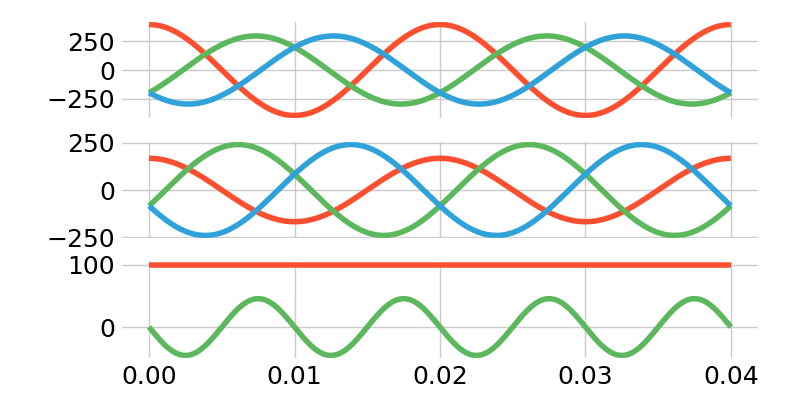

In [191]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 4), sharex = True)

axes[0].plot(t, v_a)
axes[0].plot(t, v_b)
axes[0].plot(t, v_c)

axes[1].plot(t, i_a)
axes[1].plot(t, i_b)
axes[1].plot(t, i_c)

axes[2].plot(t, p/1000)
axes[2].plot(t, q/1000)

### Reference following check

In [192]:
I_012 = A_a0 @ I_abc 
i_dq_z_out = I_012[0]*np.exp(-1j*theta_pll)*np.sqrt(2)
i_dq_p_out = I_012[1]*np.exp(-1j*theta_pll)*np.sqrt(2)
i_dq_n_out = I_012[2]*np.exp(-1j*theta_pll)*np.sqrt(2)

i_d_p = i_dq_p_out.real
i_q_p = i_dq_p_out.imag
i_d_n = i_dq_n_out.real
i_q_n = i_dq_n_out.imag

print(i_d_p_ref,i_dq_p_out.real)
print(i_q_p_ref,i_dq_p_out.imag)
print(i_d_n_ref,i_dq_n_out.real)
print(i_q_n_ref,i_dq_n_out.imag)

p_cte_ref = 1.5*i_d_n*v_d_n + 1.5*i_d_p*v_d_p + 1.5*i_q_n*v_q_n + 1.5*i_q_p*v_q_p
p_cos_ref = 1.5*i_d_n*v_d_p + 1.5*i_d_p*v_d_n + 1.5*i_q_n*v_q_p + 1.5*i_q_p*v_q_n
p_sin_ref =-1.5*i_d_n*v_q_p + 1.5*i_d_p*v_q_n + 1.5*i_q_n*v_d_p - 1.5*i_q_p*v_d_n
q_cte_ref = 1.5*i_d_n*v_q_n + 1.5*i_d_p*v_q_p - 1.5*i_q_n*v_d_n - 1.5*i_q_p*v_d_p
q_cos_ref = 1.5*i_d_n*v_q_p + 1.5*i_d_p*v_q_n - 1.5*i_q_n*v_d_p - 1.5*i_q_p*v_d_n
q_sin_ref = 1.5*i_d_n*v_d_p - 1.5*i_d_p*v_d_n + 1.5*i_q_n*v_q_p - 1.5*i_q_p*v_q_n

lhs = ['p_cte_ref','p_cos_ref','p_sin_ref','q_cte_ref','q_cos_ref','q_sin_ref']
rhs = [p_cte_ref,p_cos_ref,p_sin_ref,q_cte_ref,q_cos_ref,q_sin_ref]
for lh,rh in zip(lhs,rhs):
    print('{:s}_ref = {:s}'.format(str(lh) ,str(sym.simplify(rh))))


214.16303762 [ 214.16303762]
0.0 [ -9.40609961e-12]
-46.3676577827 [-46.36765778]
-7.45434746589e-15 [  5.29680241e-12]
p_cte_ref_ref = 99999.9999999998
p_cos_ref_ref = -5.09317032992841e-11
p_sin_ref_ref = 3.59621202825744e-9
q_cte_ref_ref = 4.04542751205649e-9
q_cos_ref_ref = -1.59357324446268e-9
q_sin_ref_ref = -45430.8408542657


### Positive sequence calculation

In [ ]:
Z = R +1j *L*omega
I_pos = (e_p - v_p)/Z
I_pos

In [ ]:
S  =V_abc.T @ np.conj(I_abc)
S

In [ ]:
I_012 = A_a0 @ I_abc 
I_012*np.sqrt(2)

In [ ]:
import sympy as sym

In [ ]:
v_d_p,v_q_p,v_d_n,v_q_n = sym.symbols('v_d_p,v_q_p,v_d_n,v_q_n')

i2p = sym.Matrix([[ v_d_p, v_q_p, v_d_n, v_q_n],
                  [-v_q_p, v_d_p,-v_q_n, v_d_n],
                  [-v_q_n, v_d_n, v_q_p,-v_d_p],
                  [ v_d_n, v_q_n, v_d_p, v_q_p]])


p2i = sym.simplify(i2p.inv())

In [ ]:
sym.simplify(p2i)

In [ ]:
theta = np.deg2rad(0.0)
phi = np.deg2rad(90.0)
V_zero =  0.0*np.exp(1j*0.0)
V_neg  =100.0*np.exp(1j*0.0)
V_pos  =231.0*np.exp(1j*theta)

V_012 = np.array([[V_zero],[V_pos],[V_neg]])

V_abc = A_0a @ V_012

I_zero =   0.0*np.exp(1j*0.0)
I_neg  =   0.0*np.exp(1j*(theta+phi))
I_pos  = 10.0*np.exp(1j*(theta-phi))

s_012 = 500e3
sin_012 = 0.0
cos_012 = 0.0
I_pos = (V_neg*sin_012 - V_pos*s_012)/(3*(V_neg**2 - V_pos**2))
I_neg = (V_neg*s_012 - V_pos*sin_012)/(3*(V_neg**2 - V_pos**2))

#I_pos = (-V_neg*sin_012 + V_pos*s_012)/(3*(V_neg**2 + V_pos**2))
#I_neg = ( V_neg*s_012 + V_pos*sin_012)/(3*(V_neg**2 + V_pos**2))
#I = 1j
#I_pos = 0.333333333333333*(V_neg*sin_012 - V_pos*s_012*(1.0 + I))/(V_neg**2*(1.0 - I) - V_pos**2*(1.0 + I))
#I_neg = 0.333333333333333*(V_neg*s_012*(1.0 - I) - V_pos*sin_012)/(V_neg**2*(1.0 - I) - V_pos**2*(1.0 + I))

#I_pos = 0.333333333333333*(V_neg*sin_012 - V_pos*s_012*(1.0 - I))/(V_neg**2*(1.0 + I) - V_pos**2*(1.0 - I))
#I_neg = 0.333333333333333*(V_neg*s_012*(1.0 + I) - V_pos*sin_012)/(V_neg**2*(1.0 + I) - V_pos**2*(1.0 - I))

#I_pos = 0.333333333333333*(I*V_neg*cos_012 + V_pos*s_012)/(V_neg**2 + V_pos**2)
#I_neg = 0.333333333333333*(V_neg*s_012 - I*V_pos*cos_012)/(V_neg**2 + V_pos**2)

#I_pos= (0.166666666666667 - 0.166666666666667*I)*(V_neg*(cos_012 + sin_012) - V_pos*s_012*(1.0 + I))/(V_neg**2 - V_pos**2)
#I_neg= (0.166666666666667 - 0.166666666666667*I)*(V_neg*s_012*(1.0 + I) - V_pos*(cos_012 + sin_012))/(V_neg**2 - V_pos**2)

#I_neg = (cos_012 + sin_012)/(6*V_pos)
#I_pos = (-V_neg*(cos_012 + sin_012) + 2*V_pos*s_012)/(6*V_pos**2)
I_pos = np.conj(s_012/(3*V_pos))
I_neg = -V_neg*I_pos/(V_pos)

I_012 = np.array([[I_zero],[I_pos],[I_neg]])

I_abc = A_0a @ I_012


In [ ]:
v_abc = (np.exp(1j*2.0*np.pi*50.0*t)*V_abc).real*np.sqrt(2)
i_abc = (np.exp(1j*2.0*np.pi*50.0*t)*I_abc).real*np.sqrt(2)

p = np.sum(v_abc * i_abc, axis=0)
q = -((v_abc[1]- v_abc[2]) * i_abc[0] + (v_abc[2]- v_abc[0]) * i_abc[1]  + (v_abc[0]- v_abc[1]) * i_abc[2] )/np.sqrt(3)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 6), sharex = True)

axes[0].plot(t, v_abc[0,:])
axes[0].plot(t, v_abc[1,:])
axes[0].plot(t, v_abc[2,:])

axes[1].plot(t, i_abc[0,:])
axes[1].plot(t, i_abc[1,:])
axes[1].plot(t, i_abc[2,:])

axes[2].plot(t, p/1000)
axes[2].plot(t, q/1000)

In [ ]:
3*V_pos*I_pos

In [ ]:
3*V_neg*I_neg

In [ ]:
s_012 = 3*V_pos*I_pos + 3*V_neg*I_neg

In [ ]:
s_012

In [ ]:
sin_012 = 3*V_pos*I_neg + 3*V_neg*I_pos 
cos_012 = 3*V_pos*I_neg - 3*V_neg*I_pos

In [ ]:
print(sin_012,cos_012)

In [ ]:
s_012,sin_012,cos_012,V_pos,I_pos,V_neg,I_neg = sym.symbols('s_012,sin_012,cos_012,V_pos,I_pos,V_neg,I_neg ')

sin_012_ = 3*V_pos*I_neg + 3*V_neg*I_pos 
cos_012_ = 3*V_pos*I_neg - 3*V_neg*I_pos

eq1 = -s_012 + 3*V_pos*I_pos + 3*V_neg*I_neg
eq2 = sin_012-sin_012_ - cos_012+cos_012_
sym.solve([eq1,eq2],[I_pos,I_neg])

In [ ]:
I_pos

In [ ]:
from sympy.functions import re,im

v_d_p,v_q_p,v_d_n,v_q_n,i_d_p,i_q_p,i_d_n,i_q_n,wt = sym.symbols('v_d_p,v_q_p,v_d_n,v_q_n,i_d_p,i_q_p,i_d_n,i_q_n,wt',real=True)
p_ref,q_ref = sym.symbols('p_ref,q_ref',real=True)

exp_p = sym.cos( wt)+1j*sym.sin( wt)
exp_n = sym.cos(-wt)+1j*sym.sin(-wt)

v_dq_p = v_d_p + 1j*v_q_p
v_dq_n = v_d_n + 1j*v_q_n
i_dq_p = i_d_p + 1j*i_q_p
i_dq_n = i_d_n + 1j*i_q_n

s = 3/2*(v_dq_p*exp_p + v_dq_n*exp_n)*sym.conjugate(i_dq_p*exp_p + i_dq_n*exp_n)
s = sym.simplify(sym.factor(sym.expand(s)))


In [ ]:
p = sym.collect(re(s),[sym.cos(2*wt),sym.sin(2*wt)])
q = sym.collect(im(s),[sym.cos(2*wt),sym.sin(2*wt)])

In [ ]:
s

In [ ]:
p_cos = p.diff(sym.cos(2*wt))
p_sin = p.diff(sym.sin(2*wt))
p_cte = sym.simplify(p - p_cos*sym.cos(2*wt) - p_sin*sym.sin(2*wt))
q_cos = q.diff(sym.cos(2*wt))
q_sin = q.diff(sym.sin(2*wt))
q_cte = sym.simplify(q - q_cos*sym.cos(2*wt) - q_sin*sym.sin(2*wt))

In [ ]:
lhs = ['p_cte','p_cos','p_sin','q_cte','q_cos','q_sin']
rhs = [p_cte,p_cos,p_sin,q_cte,q_cos,q_sin]
for lh,rh in zip(lhs,rhs):
    print('{:s}_ref = {:s}'.format(str(lh) ,str(sym.simplify(rh))))

### References for p constant

In [ ]:
sol = sym.solve([p_cte-p_ref,q_cte-q_ref,p_cos,p_sin],[i_d_p,i_q_p,i_d_n,i_q_n])
for item in [i_d_p,i_q_p,i_d_n,i_q_n]:
    print('{:s}_ref = {:s}'.format(str(item) ,str(sym.simplify(sol[item]))))

### References for q constant

In [ ]:
sol = sym.solve([p_cte-p_ref,q_cte-q_ref,q_cos,q_sin],[i_d_p,i_q_p,i_d_n,i_q_n])
for item in [i_d_p,i_q_p,i_d_n,i_q_n]:
    print('{:s}_ref = {:s}'.format(str(item) ,str(sym.simplify(sol[item]))))

### References for p and q constant

In [ ]:
sol = sym.solve([p_cte-p_ref,q_cte-q_ref,p_cos,q_sin],[i_d_p,i_q_p,i_d_n,i_q_n])
for item in [i_d_p,i_q_p,i_d_n,i_q_n]:
    print('{:s}_ref = {:s}'.format(str(item) ,str(sym.simplify(sol[item]))))

In [ ]:
sym.simplify(p_cos-q_sin)

In [ ]:
sym.simplify(p_sin-q_cos)

### 012, abc, dq0, etc.

In [ ]:
theta = np.deg2rad(0.0)
delta = np.deg2rad(0.0)
V_z =  0.0*np.exp(1j*0.0)
V_p = 400.0/np.sqrt(3)*np.exp(1j*theta)
V_n = 50.0*np.exp(1j*0.0)

E_z =  0.0*np.exp(1j*0.0)
E_p = 420.0/np.sqrt(3)*np.exp(1j*(theta+delta))
E_n =    0.0*np.exp(1j*0.0)


V_012 = np.array([[V_z],[V_p],[V_n]])
E_012 = np.array([[E_z],[E_p],[E_n]])

V_abc = A_0a @ V_012
E_abc = A_0a @ E_012

L = 200.0e-6
R = 0.01
Omega = 2*np.pi*50.0

### Current with dq

In [ ]:
from sympy.functions import re,im

v_d_p,v_q_p,v_d_n,v_q_n = sym.symbols('v_d_p,v_q_p,v_d_n,v_q_n',real=True)
i_d_p,i_q_p,i_d_n,i_q_n = sym.symbols('i_d_p,i_q_p,i_d_n,i_q_n',real=True)
e_d_p,e_q_p,e_d_n,e_q_n = sym.symbols('e_d_p,e_q_p,e_d_n,e_q_n',real=True)
R,L,Omega= sym.symbols('R,L,Omega',real=True)

di_d_p = 1.0/L*(e_d_p - R*i_d_p + L*Omega*i_q_p - v_d_p)
di_q_p = 1.0/L*(e_q_p - R*i_q_p - L*Omega*i_d_p - v_q_p)
di_d_n = 1.0/L*(e_d_n - R*i_d_n + L*Omega*i_q_n - v_d_n)
di_q_n = 1.0/L*(e_q_n - R*i_q_n - L*Omega*i_d_n - v_q_n)

sol = sym.solve([di_d_p,di_q_p,di_d_n,di_q_n],[i_d_p,i_q_p,i_d_n,i_q_n])

for item in [i_d_p,i_q_p,i_d_n,i_q_n]:
    print('{:s} = {:s}'.format(str(item) ,str(sym.simplify(sol[item]))))

In [ ]:
# Park:
theta_pll = 0.0

v_dq_z = V_z*np.exp( 1j*theta_pll)*np.sqrt(2)
v_dq_p = V_p*np.exp( 1j*theta_pll)*np.sqrt(2)
v_dq_n = V_n*np.exp( 1j*theta_pll)*np.sqrt(2)

v_d_z = v_dq_z.real
v_q_z = v_dq_z.imag
v_d_p = v_dq_p.real
v_q_p = v_dq_p.imag
v_d_n = v_dq_n.real
v_q_n = v_dq_n.imag

e_dq_z = E_z*np.exp( 1j*theta_pll)*np.sqrt(2)
e_dq_p = E_p*np.exp( 1j*theta_pll)*np.sqrt(2)
e_dq_n = E_n*np.exp( 1j*theta_pll)*np.sqrt(2)

e_d_z = e_dq_z.real
e_q_z = e_dq_z.imag
e_d_p = e_dq_p.real
e_q_p = e_dq_p.imag
e_d_n = e_dq_n.real
e_q_n = e_dq_n.imag


i_d_p = (L*Omega*e_q_p - L*Omega*v_q_p + R*e_d_p - R*v_d_p)/(L**2*Omega**2 + R**2)
i_q_p = (-L*Omega*e_d_p + L*Omega*v_d_p + R*e_q_p - R*v_q_p)/(L**2*Omega**2 + R**2)
i_d_n = (-L*Omega*e_q_n + L*Omega*v_q_n + R*e_d_n - R*v_d_n)/(L**2*Omega**2 + R**2)
i_q_n = (L*Omega*e_d_n - L*Omega*v_d_n + R*e_q_n - R*v_q_n)/(L**2*Omega**2 + R**2)

i_d_p = (-L*Omega*e_q_p + L*Omega*v_q_p + R*e_d_p - R*v_d_p)/(L**2*Omega**2 + R**2)
i_q_p = (L*Omega*e_d_p - L*Omega*v_d_p + R*e_q_p - R*v_q_p)/(L**2*Omega**2 + R**2)
i_d_n = (L*Omega*e_q_n - L*Omega*v_q_n + R*e_d_n - R*v_d_n)/(L**2*Omega**2 + R**2)
i_q_n = (-L*Omega*e_d_n + L*Omega*v_d_n + R*e_q_n - R*v_q_n)/(L**2*Omega**2 + R**2)

i_d_p = (L*Omega*e_q_p - L*Omega*v_q_p + R*e_d_p - R*v_d_p)/(L**2*Omega**2 + R**2)
i_q_p = (-L*Omega*e_d_p + L*Omega*v_d_p + R*e_q_p - R*v_q_p)/(L**2*Omega**2 + R**2)
i_d_n = (L*Omega*e_q_n - L*Omega*v_q_n + R*e_d_n - R*v_d_n)/(L**2*Omega**2 + R**2)
i_q_n = (-L*Omega*e_d_n + L*Omega*v_d_n + R*e_q_n - R*v_q_n)/(L**2*Omega**2 + R**2)

i_z = 0.0
i_p = i_d_p + 1j*i_q_p
i_n = i_d_n + 1j*i_q_n

I_abc = A_0a @ np.array([i_z,i_p,i_n]).reshape(3,1)/np.sqrt(2) 
I_abc


## Current with abc and primitive

In [ ]:
Z_1 = R + 1j*Omega*L
Z_0 = 1.0e6
Z_2 = Z_1

Z_012 = np.diag([Z_0,Z_1,Z_2])
Z_abc = A_0a @ Z_012 @ A_a0

I_abc = np.linalg.solve(Z_abc,E_abc-V_abc)
I_abc

## Current with 012 and sequence impedances

In [ ]:
I_z = (E_z - V_z)/Z_0
I_p = (E_p - V_p)/Z_1
I_n = (E_n - V_n)/Z_2

I_abc = A_0a @ np.array([I_z,I_p,I_n]).reshape(3,1) 
I_abc

## Powers

In [ ]:
V_abc.T @ np.conj(I_abc)

In [ ]:
t = np.linspace(0.0,0.04,200)

v_abc = np.real(V_abc*np.exp(1j*Omega*t))*np.sqrt(2)
i_abc = np.real(I_abc*np.exp(1j*Omega*t))*np.sqrt(2)

p = np.sum(v_abc*i_abc,axis=0)
q = -((v_abc[1]- v_abc[2]) * i_abc[0] + (v_abc[2]- v_abc[0]) * i_abc[1]  + (v_abc[0]- v_abc[1]) * i_abc[2] )/np.sqrt(3)
q = -((v_abc[2]- v_abc[1]) * i_abc[0] + (v_abc[0]- v_abc[2]) * i_abc[1]  + (v_abc[1]- v_abc[0]) * i_abc[2] )/np.sqrt(3)

#q = (i_a*(v_c-v_b) + i_b*(v_a-v_c) + i_c*(v_b-v_a))/np.sqrt(3)
P = np.sum(p)/200
Q = np.sum(q)/200

print('S = ',P+1j*Q)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 6), sharex = True)

axes[0].plot(t, v_abc[0,:])
axes[0].plot(t, v_abc[1,:])
axes[0].plot(t, v_abc[2,:])

axes[1].plot(t, i_abc[0,:])
axes[1].plot(t, i_abc[1,:])
axes[1].plot(t, i_abc[2,:])

axes[2].plot(t, p/1000)
axes[2].plot(t, q/1000)

A_0a @ V_012 = Z_abc @ A_0a @ I_012
A_0a @ V_012 = Z_abc @ A_0a @ I_012
V_012 = A_a0 @ Z_abc @ A_0a @ I_012
Z_012 = A_a0 @ Z_abc @ A_0a


In [ ]:
p_cte_ref = 1.5*i_d_n*v_d_n + 1.5*i_d_p*v_d_p + 1.5*i_q_n*v_q_n + 1.5*i_q_p*v_q_p
p_cos_ref = 1.5*i_d_n*v_d_p + 1.5*i_d_p*v_d_n + 1.5*i_q_n*v_q_p + 1.5*i_q_p*v_q_n
p_sin_ref =-1.5*i_d_n*v_q_p + 1.5*i_d_p*v_q_n + 1.5*i_q_n*v_d_p - 1.5*i_q_p*v_d_n
q_cte_ref = 1.5*i_d_n*v_q_n + 1.5*i_d_p*v_q_p - 1.5*i_q_n*v_d_n - 1.5*i_q_p*v_d_p
q_cos_ref = 1.5*i_d_n*v_q_p + 1.5*i_d_p*v_q_n - 1.5*i_q_n*v_d_p - 1.5*i_q_p*v_d_n
q_sin_ref = 1.5*i_d_n*v_d_p - 1.5*i_d_p*v_d_n + 1.5*i_q_n*v_q_p - 1.5*i_q_p*v_q_n
p_cte_ref

In [ ]:
p_cos_ref

In [ ]:
p_sin_ref

In [ ]:
q_cte_ref